In [1]:
#trying this tutorial: https://www.natekratzer.com/posts/census_map/
import numpy as np
import geopandas as gpd
import requests
import pandas as pd

In [2]:
#reading in file and mapping counties using WI as example
county_shp = gpd.read_file('cb_2022_us_county_500k.zip')
CA_counties = county_shp[county_shp.STATE_NAME == 'California']

In [3]:
#wi_counties.explore()

In [4]:
#load API key
with open('/Users/isabellevea/Downloads/census_api_key.txt') as key:
    api_key=key.read().strip()

#specify the data source by year and survey
year = '2020'
dsource = 'dec' #Decennial Census
dname = 'dhc' #Demographic and Housing Characteristics
base_url = f'https://api.census.gov/data/{year}/{dsource}/{dname}'

#unique to this specific data request
cols = 'NAME,P1_001N' #NAME of geography as well as the variables I want to pull
geo = 'county:*' #county geography level
state = 'state:*' #all states

#add unique request features to the base_url
data_url = f'{base_url}?get={cols}&for={geo}&in={state}&key={api_key}'

#go get the data
response = requests.get(data_url)



In [5]:
#take the data in json and format it into a dataframe
data = response.json()

In [6]:
df = pd.DataFrame(data = data[1:], columns = data[0])
df.head()

,NAME,P1_001N,state,county
0,"Madera County, California",156255,06,039
1,"Marin County, California",262321,06,041
2,"Mariposa County, California",17131,06,043
3,"Mendocino County, California",91601,06,045
4,"Merced County, California",281202,06,047


In [7]:
#rename columns and convert population to numeric
df.rename(columns = {'NAME': 'county_name', 'P1_001N': 'population', 'state': 'state_fips', 'county': 'county_fips'}, inplace=True)
df['population'] = df['population'].apply(pd.to_numeric)

In [8]:
df['fips'] = df['state_fips'] + df['county_fips']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3221 entries, 0 to 3220
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   county_name  3221 non-null   object
 1   population   3221 non-null   int64 
 2   state_fips   3221 non-null   object
 3   county_fips  3221 non-null   object
 4   fips         3221 non-null   object
dtypes: int64(1), object(4)
memory usage: 125.9+ KB


In [9]:
#states = county_shp.STATE_NAME.values.tolist()
#print(states)

In [10]:
#creating a full US map
#usa_counties = county_shp[county_shp.STATE_NAME == states]


In [11]:
#usa_counties.explore()

In [12]:
#construct the fips code to match with the geography data
#usa_counties['fips'] = usa_counties['STATEFP'] + usa_counties['COUNTYFP']
#usa_counties.head()

In [13]:
#merge in the new data
#clean up the names to be a bit more presentable
#df_map = (CA_counties.merge(df, how = 'left', on = 'fips').rename(columns = {'NAMELSAD': 'County Name', 'population': 'County Population'}))

#df_map.head()

In [14]:
#df_map.explore(
    #column ='County Population',
    #scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    #legend=True,  # show legend
    #k=5,  # use 5 bins
    #tooltip = ['County Name', 'County Population'],
    #tiles = 'CartoDB positron', #fades into the background better than the default
    #legend_kwds=dict(colorbar=False, color="gray"))

In [15]:
#biggest_counties = df_map[df_map['County Population'] > 5000000]
#biggest_counties

In [16]:
#another approach I found, but did not work well bc of size of dataset and rate limits
#pip install geopy

In [17]:
#note: rate limit became a problem; will need to filter down to CA data only before retrying
#from geopy.geocoders import Nominatim

#def get_zip_code(latitude, longitude): 
    #geolocator = Nominatim(user_agent="mafphd@icloud.com")
    #location = geolocator.reverse((latitude, longitude), exactly_one=True)
    #address = location.raw['address']
    #zip_code = address.get('postcode')
    
    #return zip_code

In [18]:
import pandas as pd
burn = pd.read_csv('Burn_Severity_Trends.csv')
burn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30418 entries, 0 to 30417
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X                    30418 non-null  float64
 1   Y                    30418 non-null  float64
 2   OBJECTID             30418 non-null  int64  
 3   FIRE_ID              30418 non-null  object 
 4   FIRE_NAME            30418 non-null  object 
 5   ASMNT_TYPE           30418 non-null  object 
 6   FIRE_TYPE            30418 non-null  object 
 7   NODATA_THRESHOLD     30418 non-null  int64  
 8   GREENNESS_THRESHOLD  30418 non-null  int64  
 9   LOW_THRESHOLD        30418 non-null  int64  
 10  MODERATE_THRESHOLD   30418 non-null  int64  
 11  HIGH_THRESHOLD       30418 non-null  int64  
 12  IG_DATE              30418 non-null  object 
 13  LATITUDE             30418 non-null  float64
 14  LONGITUDE            30418 non-null  float64
 15  ACRES                30418 non-null 

In [19]:
#burn['ZIP_CODE'] = burn.apply(lambda row: get_zip_code(row['LATITUDE'], row['LONGITUDE']), axis=1)
burn.head()

,X,Y,OBJECTID,FIRE_ID,FIRE_NAME,ASMNT_TYPE,FIRE_TYPE,NODATA_THRESHOLD,GREENNESS_THRESHOLD,LOW_THRESHOLD,...,ACRES,IRWINID,MAP_ID,MAP_PROG,PERIM_ID,DNBR_OFFST,DNBR_STDDV,COMMENTS,PRE_ID,POST_ID
0,-144.673246,64.482309,830721,AK6448214467319840607,GLACIER CREEK,Initial (SS),Wildfire,9999,9999,550,...,1897,NaN,4534,MTBS,506601519860705,-9999,-9999,NaN,NaN,506801519840713
1,-102.849877,43.083926,830722,SD4308410285019840906,SANDOZ,Initial,Wildfire,-970,-150,220,...,2691,NaN,4535,MTBS,NaN,211,-9999,NaN,503303019840622,503303019840926
2,-113.457720,48.804345,830723,MT4880411345819840819,NAPI PEAK,Extended,Wildfire,-970,-150,160,...,3680,NaN,4536,MTBS,NaN,-62,-9999,NaN,504102619840614,504102619850719
3,-106.958289,45.336400,830724,MT4533610695819840826,KIRBY,Extended,Wildfire,-970,-150,150,...,1597,NaN,4537,MTBS,NaN,52,-9999,NaN,503602819840814,503602819850817
4,-106.322839,45.616844,830725,MT4561710632319840918,LAKE CREEK,Initial,Wildfire,-970,-150,-50,...,3617,NaN,4538,MTBS,NaN,-104,-9999,NaN,503602819840814,503602819841017


In [20]:
#trying to identify counties by latitude/longitude coordinates using TIGER/Line Shapefile, 2019, nation, U.S., Current County and Equivalent National Shapefile from data.gov
import geopandas as gpd

# Load the shapefile
#gdf = gpd.read_file('/Users/isabellevea/Downloads/tl_2019_us_county/tl_2019_us_county.shp') #file is too large to commit; download from https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-county-and-equivalent-national-shapefile

gdf = gpd.read_file('data/census_CA.shp') #file is too large to commit; download from https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-county-and-equivalent-national-shapefile


In [21]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [22]:
gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,NaN,NaN,A,2468694583,23299110,+39.5769252,-120.5219926,"POLYGON ((-120.65559 39.69356, -120.65552 39.6..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,NaN,A,2499983887,75425434,+38.4500161,-121.3404408,"POLYGON ((-121.18857 38.71431, -121.18731 38.7..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,NaN,42200,NaN,A,7084063392,2729751706,+34.5370572,-120.0399729,"MULTIPOLYGON (((-120.73429 34.90069, -120.7343..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,NaN,NaN,NaN,A,2641784992,43841871,+38.1838996,-120.5614415,"POLYGON ((-120.63093 38.34110, -120.63057 38.3..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,NaN,A,4771987962,947345370,+34.3587415,-119.1331432,"MULTIPOLYGON (((-119.32922 34.22784, -119.3292..."


In [23]:
def get_county_name(latitude, longitude):
    point = gpd.GeoDataFrame(geometry=gpd.points_from_xy([longitude], [latitude]))
    county = gdf[gdf.contains(point.unary_union)]
    return county['NAME'].iloc[0] if not county.empty else None

In [24]:
# Example usage
latitude = 37.7749  # Example latitude
longitude = -122.4194  # Example longitude

county_name = get_county_name(latitude, longitude)
print("County Name:", county_name)


County Name: San Francisco


In [25]:
burn['County'] = burn.apply(lambda row: get_county_name(row['LATITUDE'], row['LONGITUDE']), axis=1)

In [26]:
burn['County'].isna().sum()

28432

In [27]:
#looking at the missing counties to see if any are within approximate CA coordinates (from ChatGPT/verified on a map: min_lat = 32.5, max_lat = 37.0,min_lon = -125.0,max_lon = -114.0)
missing_ctys = burn[burn['County'].isna()]
missing_ctys_sorted = missing_ctys[['LATITUDE', 'LONGITUDE']]
missing_ctys_sorted.sort_values(by='LATITUDE', ascending = True)

,LATITUDE,LONGITUDE
12042,17.957,-66.129
14370,17.986,-67.039
12020,18.007,-66.312
12043,18.009,-66.210
12021,18.025,-66.266
...,...,...
19425,69.260,-155.391
13805,69.465,-148.350
26215,69.686,-159.607
26214,69.765,-159.058


In [28]:
#using BallTree nearest neighbors approach to fill in County based on closest known lat/long coordinates
from sklearn.neighbors import BallTree

# Assuming 'burn' is your original DataFrame

# Create a subset DataFrame with only rows that have County information
known_counties = burn.dropna(subset=['County'])

# Extract latitude and longitude for known counties
known_coordinates = known_counties[['LATITUDE', 'LONGITUDE']].values

# Build a BallTree for efficient nearest neighbor search
tree = BallTree(known_coordinates, leaf_size=15)

# Define a function to impute missing County values based on nearest neighbors
def impute_county(row):
    if pd.isna(row['County']):
        distances, indices = tree.query([[row['LATITUDE'], row['LONGITUDE']]], k=1)
        closest_county = known_counties.iloc[indices[0][0]]['County']
        return closest_county
    else:
        return row['County']

# Apply the impute_county function to fill in missing values
burn['County'] = burn.apply(impute_county, axis=1)


In [29]:
burn['County'].isna().sum()

0

In [30]:
#checking to see if I can get fips codes from the shapefile to join the two dataframes
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   58 non-null     object  
 1   COUNTYFP  58 non-null     object  
 2   COUNTYNS  58 non-null     object  
 3   GEOID     58 non-null     object  
 4   NAME      58 non-null     object  
 5   NAMELSAD  58 non-null     object  
 6   LSAD      58 non-null     object  
 7   CLASSFP   58 non-null     object  
 8   MTFCC     58 non-null     object  
 9   CSAFP     31 non-null     object  
 10  CBSAFP    45 non-null     object  
 11  METDIVFP  7 non-null      object  
 12  FUNCSTAT  58 non-null     object  
 13  ALAND     58 non-null     int64   
 14  AWATER    58 non-null     int64   
 15  INTPTLAT  58 non-null     object  
 16  INTPTLON  58 non-null     object  
 17  geometry  58 non-null     geometry
dtypes: geometry(1), int64(2), object(15)
memory usage: 8.3+ KB


In [31]:
# bringing FP codes to the burn dataframe for joining
# Spatial join between burn DataFrame and shapefile
gdf = gdf[['STATEFP', 'COUNTYFP', 'geometry']]  # Select only necessary columns
burn_gdf = gpd.GeoDataFrame(burn, geometry=gpd.points_from_xy(burn.LONGITUDE, burn.LATITUDE), crs=gdf.crs)
merged = gpd.sjoin(burn_gdf, gdf, how='left', op='within')

# Extract STATEFP and COUNTYFP values
burn['state_fips'] = merged['STATEFP']
burn['county_fips'] = merged['COUNTYFP']

# Create 'fips' column by concatenating 'state_fips' and 'county_fips'
burn['fips'] = burn['state_fips'].astype(str) + burn['county_fips'].astype(str)


/Users/isabellevea/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [32]:
burn.head()

,X,Y,OBJECTID,FIRE_ID,FIRE_NAME,ASMNT_TYPE,FIRE_TYPE,NODATA_THRESHOLD,GREENNESS_THRESHOLD,LOW_THRESHOLD,...,PERIM_ID,DNBR_OFFST,DNBR_STDDV,COMMENTS,PRE_ID,POST_ID,County,state_fips,county_fips,fips
0,-144.673246,64.482309,830721,AK6448214467319840607,GLACIER CREEK,Initial (SS),Wildfire,9999,9999,550,...,506601519860705,-9999,-9999,NaN,NaN,506801519840713,Del Norte,NaN,NaN,nannan
1,-102.849877,43.083926,830722,SD4308410285019840906,SANDOZ,Initial,Wildfire,-970,-150,220,...,NaN,211,-9999,NaN,503303019840622,503303019840926,San Bernardino,NaN,NaN,nannan
2,-113.457720,48.804345,830723,MT4880411345819840819,NAPI PEAK,Extended,Wildfire,-970,-150,160,...,NaN,-62,-9999,NaN,504102619840614,504102619850719,Modoc,NaN,NaN,nannan
3,-106.958289,45.336400,830724,MT4533610695819840826,KIRBY,Extended,Wildfire,-970,-150,150,...,NaN,52,-9999,NaN,503602819840814,503602819850817,San Bernardino,NaN,NaN,nannan
4,-106.322839,45.616844,830725,MT4561710632319840918,LAKE CREEK,Initial,Wildfire,-970,-150,-50,...,NaN,-104,-9999,NaN,503602819840814,503602819841017,San Bernardino,NaN,NaN,nannan


In [33]:
# filtering down to California only for both dataframes
#Cali = df_map[df_map['STATE_NAME']=='California']
#Cali.head()

In [34]:
Cali_burn = burn[burn['state_fips'] == '06']
Cali_burn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 23 to 30374
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X                    1986 non-null   float64
 1   Y                    1986 non-null   float64
 2   OBJECTID             1986 non-null   int64  
 3   FIRE_ID              1986 non-null   object 
 4   FIRE_NAME            1986 non-null   object 
 5   ASMNT_TYPE           1986 non-null   object 
 6   FIRE_TYPE            1986 non-null   object 
 7   NODATA_THRESHOLD     1986 non-null   int64  
 8   GREENNESS_THRESHOLD  1986 non-null   int64  
 9   LOW_THRESHOLD        1986 non-null   int64  
 10  MODERATE_THRESHOLD   1986 non-null   int64  
 11  HIGH_THRESHOLD       1986 non-null   int64  
 12  IG_DATE              1986 non-null   object 
 13  LATITUDE             1986 non-null   float64
 14  LONGITUDE            1986 non-null   float64
 15  ACRES                1986 non-null  

In [35]:
burn_pop_merge = Cali_burn.merge(df, how = 'left', on = 'fips')
burn_pop_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X                    1986 non-null   float64
 1   Y                    1986 non-null   float64
 2   OBJECTID             1986 non-null   int64  
 3   FIRE_ID              1986 non-null   object 
 4   FIRE_NAME            1986 non-null   object 
 5   ASMNT_TYPE           1986 non-null   object 
 6   FIRE_TYPE            1986 non-null   object 
 7   NODATA_THRESHOLD     1986 non-null   int64  
 8   GREENNESS_THRESHOLD  1986 non-null   int64  
 9   LOW_THRESHOLD        1986 non-null   int64  
 10  MODERATE_THRESHOLD   1986 non-null   int64  
 11  HIGH_THRESHOLD       1986 non-null   int64  
 12  IG_DATE              1986 non-null   object 
 13  LATITUDE             1986 non-null   float64
 14  LONGITUDE            1986 non-null   float64
 15  ACRES                1986 non-null   i

In [36]:
burn_pop_merge.columns

Index(['X', 'Y', 'OBJECTID', 'FIRE_ID', 'FIRE_NAME', 'ASMNT_TYPE', 'FIRE_TYPE',
       'NODATA_THRESHOLD', 'GREENNESS_THRESHOLD', 'LOW_THRESHOLD',
       'MODERATE_THRESHOLD', 'HIGH_THRESHOLD', 'IG_DATE', 'LATITUDE',
       'LONGITUDE', 'ACRES', 'IRWINID', 'MAP_ID', 'MAP_PROG', 'PERIM_ID',
       'DNBR_OFFST', 'DNBR_STDDV', 'COMMENTS', 'PRE_ID', 'POST_ID', 'County',
       'state_fips_x', 'county_fips_x', 'fips', 'county_name', 'population',
       'state_fips_y', 'county_fips_y'],
      dtype='object')

In [37]:
#dropping extra columns
burn_pop_merge.drop(['state_fips_y', 'county_fips_y'], axis=1, inplace=True)
burn_pop_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X                    1986 non-null   float64
 1   Y                    1986 non-null   float64
 2   OBJECTID             1986 non-null   int64  
 3   FIRE_ID              1986 non-null   object 
 4   FIRE_NAME            1986 non-null   object 
 5   ASMNT_TYPE           1986 non-null   object 
 6   FIRE_TYPE            1986 non-null   object 
 7   NODATA_THRESHOLD     1986 non-null   int64  
 8   GREENNESS_THRESHOLD  1986 non-null   int64  
 9   LOW_THRESHOLD        1986 non-null   int64  
 10  MODERATE_THRESHOLD   1986 non-null   int64  
 11  HIGH_THRESHOLD       1986 non-null   int64  
 12  IG_DATE              1986 non-null   object 
 13  LATITUDE             1986 non-null   float64
 14  LONGITUDE            1986 non-null   float64
 15  ACRES                1986 non-null   i

In [38]:
burn_pop_merge.rename(columns = {'state_fips_x': 'state_fips', 'county_fips_x': 'county_fips'}, inplace=True)
burn_pop_merge.columns

Index(['X', 'Y', 'OBJECTID', 'FIRE_ID', 'FIRE_NAME', 'ASMNT_TYPE', 'FIRE_TYPE',
       'NODATA_THRESHOLD', 'GREENNESS_THRESHOLD', 'LOW_THRESHOLD',
       'MODERATE_THRESHOLD', 'HIGH_THRESHOLD', 'IG_DATE', 'LATITUDE',
       'LONGITUDE', 'ACRES', 'IRWINID', 'MAP_ID', 'MAP_PROG', 'PERIM_ID',
       'DNBR_OFFST', 'DNBR_STDDV', 'COMMENTS', 'PRE_ID', 'POST_ID', 'County',
       'state_fips', 'county_fips', 'fips', 'county_name', 'population'],
      dtype='object')

In [39]:
#writing file to csv
burn_pop_merge.to_csv('burn_severity_population.csv')

In [40]:
#extras = burn_pop_merge[burn_pop_merge['POST_ID'].isna()]
#print(extras)


In [41]:
#extras.info()

In [42]:
#dropping the two extra rows that got added, since they don't seem to have any info from the burn data
#burn_pop_merge = burn_pop_merge.dropna(subset=['POST_ID'])
#burn_pop_merge.info()

In [43]:
#pip install seaborn

In [44]:
# quick visualization of the results
#import matplotlib.pyplot as plt
#import seaborn as sns
# Group by 'County Name' and get the count of POST_ID
#county_counts = burn_pop_merge.groupby('County Name')['POST_ID'].count()

# Filter for counties with more than 5 POST_ID values
#county_counts_filtered = county_counts[county_counts > 5]

# Merge with the original DataFrame to keep 'County Population'
#merged_df = burn_pop_merge.merge(county_counts_filtered, left_on='County Name', right_index=True, suffixes=('_original', '_count'))

# Sort counties by County Population in descending order
#sorted_df = merged_df.sort_values(by='County Population', ascending=False)
# Create the bar chart
#plt.figure(figsize=(20, 6))
#sns.barplot(x=sorted_df['County Name'], y=sorted_df['POST_ID_count'],color='firebrick')
#plt.title('Counties with > 5 fire records, Sorted by Population')
#plt.xlabel('County Name')
#plt.ylabel('Fires')
#plt.xticks(rotation=90)
#plt.show()


In [45]:
#creating map visual for presentation
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [46]:
cali = pd.read_csv('burn_severity_population.csv')
cali.shape

(1986, 32)

In [47]:
cali.columns

Index(['Unnamed: 0', 'X', 'Y', 'OBJECTID', 'FIRE_ID', 'FIRE_NAME',
       'ASMNT_TYPE', 'FIRE_TYPE', 'NODATA_THRESHOLD', 'GREENNESS_THRESHOLD',
       'LOW_THRESHOLD', 'MODERATE_THRESHOLD', 'HIGH_THRESHOLD', 'IG_DATE',
       'LATITUDE', 'LONGITUDE', 'ACRES', 'IRWINID', 'MAP_ID', 'MAP_PROG',
       'PERIM_ID', 'DNBR_OFFST', 'DNBR_STDDV', 'COMMENTS', 'PRE_ID', 'POST_ID',
       'County', 'state_fips', 'county_fips', 'fips', 'county_name',
       'population'],
      dtype='object')

In [48]:
cali['fips'] = cali['fips'].astype(int)

In [49]:
ca_map = gpd.read_file('data/census_CA.shp')

In [50]:
ca_map.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,NaN,NaN,A,2468694583,23299110,+39.5769252,-120.5219926,"POLYGON ((-120.65559 39.69356, -120.65552 39.6..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,NaN,A,2499983887,75425434,+38.4500161,-121.3404408,"POLYGON ((-121.18857 38.71431, -121.18731 38.7..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,NaN,42200,NaN,A,7084063392,2729751706,+34.5370572,-120.0399729,"MULTIPOLYGON (((-120.73429 34.90069, -120.7343..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,NaN,NaN,NaN,A,2641784992,43841871,+38.1838996,-120.5614415,"POLYGON ((-120.63093 38.34110, -120.63057 38.3..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,NaN,A,4771987962,947345370,+34.3587415,-119.1331432,"MULTIPOLYGON (((-119.32922 34.22784, -119.3292..."


In [51]:
ca_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   58 non-null     object  
 1   COUNTYFP  58 non-null     object  
 2   COUNTYNS  58 non-null     object  
 3   GEOID     58 non-null     object  
 4   NAME      58 non-null     object  
 5   NAMELSAD  58 non-null     object  
 6   LSAD      58 non-null     object  
 7   CLASSFP   58 non-null     object  
 8   MTFCC     58 non-null     object  
 9   CSAFP     31 non-null     object  
 10  CBSAFP    45 non-null     object  
 11  METDIVFP  7 non-null      object  
 12  FUNCSTAT  58 non-null     object  
 13  ALAND     58 non-null     int64   
 14  AWATER    58 non-null     int64   
 15  INTPTLAT  58 non-null     object  
 16  INTPTLON  58 non-null     object  
 17  geometry  58 non-null     geometry
dtypes: geometry(1), int64(2), object(15)
memory usage: 8.3+ KB


In [52]:
ca_map['COUNTYFP'] = ca_map['COUNTYFP'].astype(int)

In [53]:
ca_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   58 non-null     object  
 1   COUNTYFP  58 non-null     int64   
 2   COUNTYNS  58 non-null     object  
 3   GEOID     58 non-null     object  
 4   NAME      58 non-null     object  
 5   NAMELSAD  58 non-null     object  
 6   LSAD      58 non-null     object  
 7   CLASSFP   58 non-null     object  
 8   MTFCC     58 non-null     object  
 9   CSAFP     31 non-null     object  
 10  CBSAFP    45 non-null     object  
 11  METDIVFP  7 non-null      object  
 12  FUNCSTAT  58 non-null     object  
 13  ALAND     58 non-null     int64   
 14  AWATER    58 non-null     int64   
 15  INTPTLAT  58 non-null     object  
 16  INTPTLON  58 non-null     object  
 17  geometry  58 non-null     geometry
dtypes: geometry(1), int64(3), object(14)
memory usage: 8.3+ KB


In [54]:
map_df = pd.merge(
    left=ca_map,
    right=cali,
    left_on='COUNTYFP',
    right_on='county_fips',
    how='left'
)

In [55]:
map_df.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,DNBR_STDDV,COMMENTS,PRE_ID,POST_ID,County,state_fips,county_fips,fips,county_name,population
0,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,...,-9999.0,NaN,504303219850717,504303219870707,Sierra,6.0,91.0,6091.0,"Sierra County, California",3236.0
1,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,...,-9999.0,NaN,504403319870714,504403319880716,Sierra,6.0,91.0,6091.0,"Sierra County, California",3236.0
2,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,...,-9999.0,NaN,504303219880826,504303219900816,Sierra,6.0,91.0,6091.0,"Sierra County, California",3236.0
3,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,...,44.0,some edit made to mapping on 4/2023,504303319930808,504303319950814,Sierra,6.0,91.0,6091.0,"Sierra County, California",3236.0
4,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,...,-9999.0,Used CA provided perimeter for some of North a...,504303319930808,504303319950814,Sierra,6.0,91.0,6091.0,"Sierra County, California",3236.0


In [56]:
map_df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'Unnamed: 0', 'X', 'Y',
       'OBJECTID', 'FIRE_ID', 'FIRE_NAME', 'ASMNT_TYPE', 'FIRE_TYPE',
       'NODATA_THRESHOLD', 'GREENNESS_THRESHOLD', 'LOW_THRESHOLD',
       'MODERATE_THRESHOLD', 'HIGH_THRESHOLD', 'IG_DATE', 'LATITUDE',
       'LONGITUDE', 'ACRES', 'IRWINID', 'MAP_ID', 'MAP_PROG', 'PERIM_ID',
       'DNBR_OFFST', 'DNBR_STDDV', 'COMMENTS', 'PRE_ID', 'POST_ID', 'County',
       'state_fips', 'county_fips', 'fips', 'county_name', 'population'],
      dtype='object')

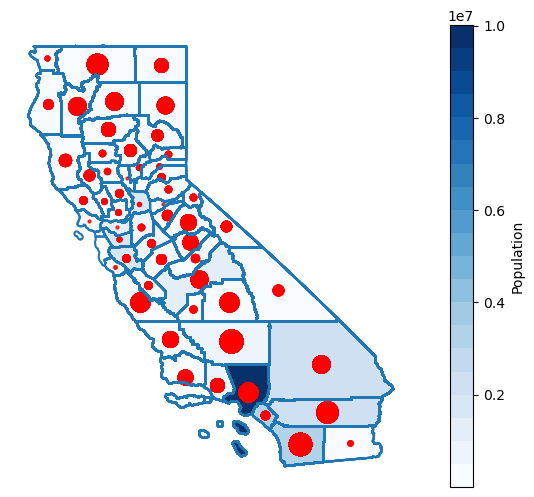

In [57]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

#Calculate the count of 'POSTID' for each county
count_per_county = map_df.groupby('county_name')['POST_ID'].count()

#Convert count_per_county to a dictionary 
circle_sizes = count_per_county.to_dict()

#Define circle sizes based on the count
circle_sizes = {county_name: count * 2 for county_name, count in circle_sizes.items()}  # Adjust the multiplier to control circle sizes

#Plot the map with circles
ax = map_df.boundary.plot(figsize=(10, 6))

#Define a custom colormap with more levels
custom_cmap = ListedColormap(plt.cm.Blues(np.linspace(0, 1, 20)))

# Plot counties with population
map_df.plot(ax=ax, column='population', legend=True, cmap=custom_cmap, legend_kwds={'label': "Population"})

# Plot circles
for idx, row in map_df.iterrows():
    county_name = row['county_name']
    centroid = row['geometry'].centroid
    plt.scatter(centroid.x, centroid.y, s=circle_sizes.get(county_name, 0), color='red', alpha=0.5)

ax.set_axis_off()  #Remove axis labels
ax.get_xaxis().set_visible(False)  #Hide x-axis
ax.get_yaxis().set_visible(False)  #Hide y-axis
plt.ticklabel_format(style='plain')

#save map file as an image
plt.savefig('CA_map.jpg', dpi=300, bbox_inches='tight')

plt.show()

Table including county, population and fire counts

In [58]:
map_df.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,DNBR_STDDV,COMMENTS,PRE_ID,POST_ID,County,state_fips,county_fips,fips,county_name,population
0,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,...,-9999.0,NaN,504303219850717,504303219870707,Sierra,6.0,91.0,6091.0,"Sierra County, California",3236.0
1,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,...,-9999.0,NaN,504403319870714,504403319880716,Sierra,6.0,91.0,6091.0,"Sierra County, California",3236.0
2,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,...,-9999.0,NaN,504303219880826,504303219900816,Sierra,6.0,91.0,6091.0,"Sierra County, California",3236.0
3,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,...,44.0,some edit made to mapping on 4/2023,504303319930808,504303319950814,Sierra,6.0,91.0,6091.0,"Sierra County, California",3236.0
4,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,...,-9999.0,Used CA provided perimeter for some of North a...,504303319930808,504303319950814,Sierra,6.0,91.0,6091.0,"Sierra County, California",3236.0


In [139]:
county_firecount_df = map_df.groupby('county_name').size().reset_index(name='fire_count')

<Axes: >

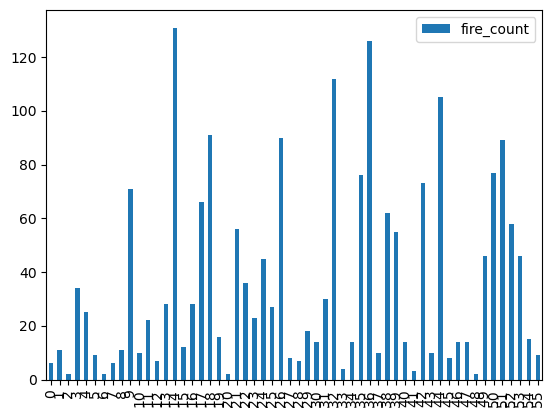

In [140]:
county_firecount_df.plot(kind='bar')

In [141]:
final_df = county_firecount_df.merge(map_df[['county_name', 'population']].drop_duplicates(), on='county_name')


In [142]:
final_df.head()

,county_name,fire_count,population
0,"Alameda County, California",6,1682353.0
1,"Alpine County, California",11,1204.0
2,"Amador County, California",2,40474.0
3,"Butte County, California",34,211632.0
4,"Calaveras County, California",25,45292.0


## Scaling merged dataset

### Standardization of population and severe fire occurences.

In [143]:
def standardize_column(df, column_name):
    """
    Standardize a column in a DataFrame using z-score normalization and return a copy of the DataFrame
    with the standardized values added as a new column.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - column_name (str): The name of the column to standardize.
    
    Returns:
    - pandas.DataFrame: A copy of the input DataFrame with standardized columns added.
    """
    # Check if the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
    # Calculate mean and standard deviation of the column
    mean_val = df[column_name].mean()
    std_val = df[column_name].std()
    
    # Standardize the column data and add it as a new column in a copy of the DataFrame
    standardized_column = (df[column_name] - mean_val) / std_val
    df_copy = df.copy()  # Create a copy of the DataFrame
    df_copy[f'{column_name}_std'] = standardized_column  # Add standardized column to the copy
    return df_copy

In [144]:
# standardize
final_df_firecount_stand = standardize_column(final_df, 'fire_count')
final_df_stand =standardize_column(final_df_firecount_stand, 'population')
final_df_stand.head()

,county_name,fire_count,population,fire_count_std,population_std
0,"Alameda County, California",6,1682353.0,-0.845503,0.674995
1,"Alpine County, California",11,1204.0,-0.702024,-0.453486
2,"Amador County, California",2,40474.0,-0.960287,-0.427126
3,"Butte County, California",34,211632.0,-0.042019,-0.312235
4,"Calaveras County, California",25,45292.0,-0.300282,-0.423892


<Axes: title={'center': 'Standardized population'}>

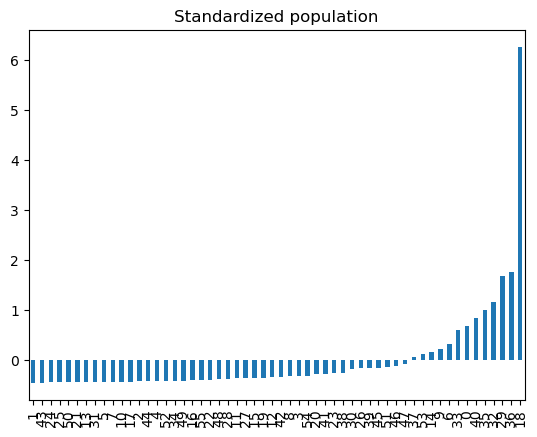

In [145]:
final_df_stand.population_std.sort_values().plot(kind='bar', title='Standardized population')

<Axes: title={'center': 'Standardized Fire counts'}>

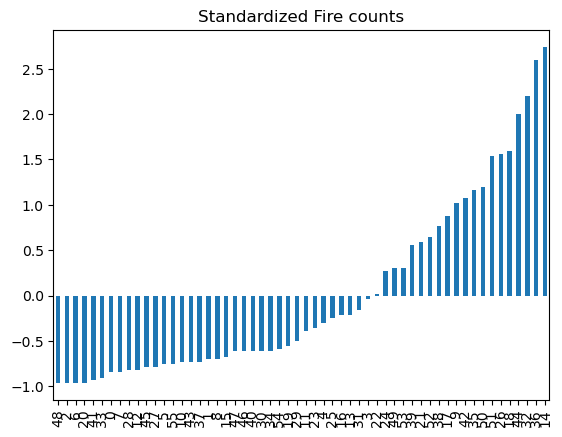

In [146]:
final_df_stand.fire_count_std.sort_values().plot(kind='bar', title='Standardized Fire counts')

## Integrating standardization with creating index based on weighting factors

In [147]:
def calculate_priority_index(df, standardize_columns, weights):
    """
    Calculate a priority index for each row in a DataFrame based on standardized values
    and weighting factors.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - standardize_columns (dict): A dictionary where keys are column names to standardize,
      and values are their corresponding weights.
    - weights (dict): A dictionary specifying the weighting factors for each standardized column.
    
    Returns:
    - pandas.DataFrame: A copy of the input DataFrame with a 'priority_index' column added.
    """
    # Copy the input DataFrame to avoid modifying the original DataFrame
    df_copy = df.copy()
    
    # Standardize each column based on the provided weights and add them to the DataFrame
    for column, weight in normalize_columns.items():
        mean_val = df[column].mean()
        std_val = df[column].std()
        standardized_column = (df[column] - mean_val) / std_val
        df_copy[f'{column}_std'] = standardized_column
        df_copy[f'{column}_weighted'] = standardized_column * weights[column]
    
    # Calculate the priority index as the sum of the weighted, standardized columns
    df_copy['priority_index'] = df_copy[[f'{column}_weighted' for column in standardize_columns]].sum(axis=1)
    
    return df_copy


In [148]:
standardize_columns = {
    'fire_count': 0.4,
    'population': 0.6,
}

In [149]:
final_df_with_priority = calculate_priority_index(final_df_stand, standardize_columns, weights=standardize_columns)

# Sort the DataFrame by the priority index in descending order to get the counties with higher priority first
final_df_with_priority = final_df_with_priority.sort_values(by='priority_index', ascending=False)


In [150]:
final_df_with_priority.head()

,county_name,fire_count,population,fire_count_std,population_std,fire_count_weighted,population_weighted,priority_index
18,"Los Angeles County, California",91,10014009.0,1.593645,6.267667,0.637458,3.760600,4.398058
36,"San Diego County, California",126,3298634.0,2.598001,1.759933,1.039200,1.055960,2.095160
32,"Riverside County, California",112,2418185.0,2.196259,1.168927,0.878503,0.701356,1.579859
14,"Kern County, California",131,909235.0,2.741480,0.156035,1.096592,0.093621,1.190213
35,"San Bernardino County, California",76,2181654.0,1.163207,1.010154,0.465283,0.606092,1.071375


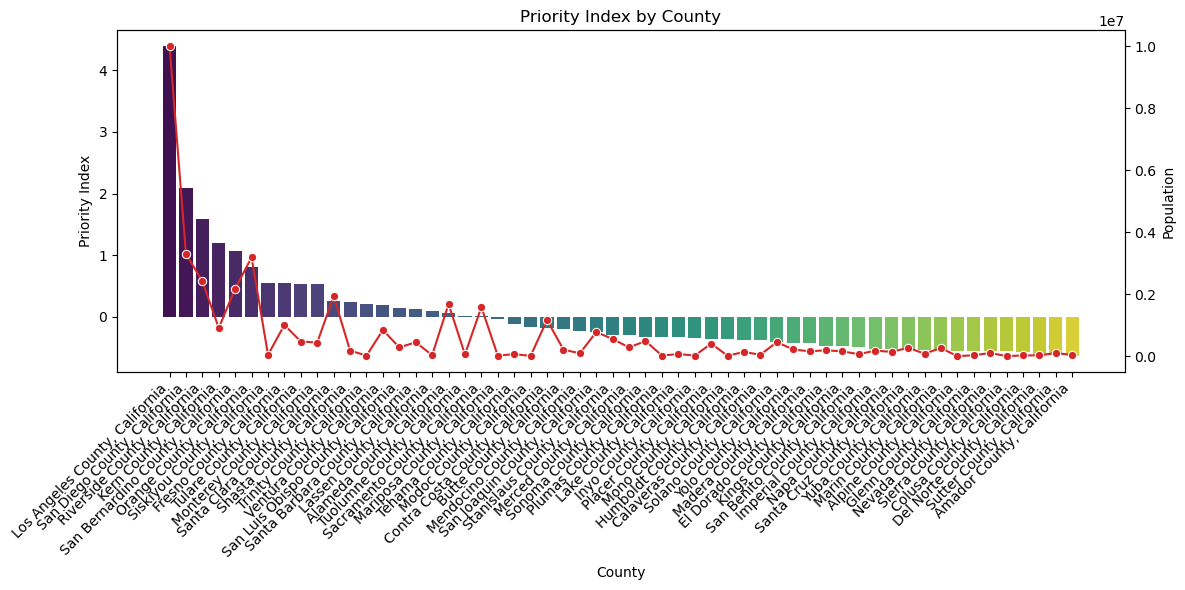

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a plot showing the priority index and population distribution
plt.figure(figsize=(12, 6))

# Plot the priority index
sns.barplot(x='county_name', y='priority_index', data=final_df_with_priority, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('County')
plt.ylabel('Priority Index')
plt.title('Priority Index by County')

# Create a second y-axis for population distribution
plt.twinx()
sns.lineplot(x='county_name', y='population', data=final_df_with_priority, color='tab:red', marker='o')
plt.ylabel('Population')
#plt.title('Population Distribution and Priority Index')

# Show the plot
plt.tight_layout()
plt.show()

In [152]:
### Create bins to index
#https://towardsdatascience.com/data-preprocessing-with-python-pandas-part-5-binning-c5bd5fd1b950

import jenkspy
breaks = jenkspy.jenks_breaks(final_df_with_priority['priority_index'], n_classes=5)


In [153]:
labels = ['priority 5','priority 4', 'priority 3', 'priority 2', 'priority 1']

In [154]:
final_df_with_priority['bin_cut_break'] = pd.cut(final_df_with_priority['priority_index'] , bins=breaks, labels=labels, include_lowest=True)

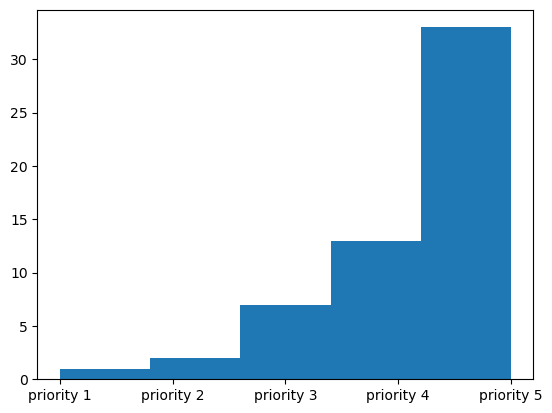

In [155]:
plt.hist(final_df_with_priority['bin_cut_break'], bins=5)
plt.show()

In [156]:
final_df_with_priority['bin_cut_break']

18    priority 1
36    priority 2
32    priority 2
14    priority 3
35    priority 3
29    priority 3
44    priority 3
9     priority 3
51    priority 3
26    priority 3
40    priority 4
42    priority 4
50    priority 4
53    priority 4
38    priority 4
39    priority 4
17    priority 4
0     priority 4
52    priority 4
33    priority 4
21    priority 4
49    priority 4
24    priority 4
6     priority 5
3     priority 5
22    priority 5
37    priority 5
47    priority 5
23    priority 5
46    priority 5
31    priority 5
16    priority 5
13    priority 5
30    priority 5
25    priority 5
11    priority 5
4     priority 5
45    priority 5
54    priority 5
19    priority 5
8     priority 5
15    priority 5
34    priority 5
12    priority 5
27    priority 5
41    priority 5
55    priority 5
20    priority 5
1     priority 5
10    priority 5
28    priority 5
43    priority 5
5     priority 5
7     priority 5
48    priority 5
2     priority 5
Name: bin_cut_break, dtype: category
Categories 

In [157]:
#merge with ca_map
ca_map.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,NaN,NaN,A,2468694583,23299110,+39.5769252,-120.5219926,"POLYGON ((-120.65559 39.69356, -120.65552 39.6..."
1,06,67,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,NaN,A,2499983887,75425434,+38.4500161,-121.3404408,"POLYGON ((-121.18857 38.71431, -121.18731 38.7..."
2,06,83,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,NaN,42200,NaN,A,7084063392,2729751706,+34.5370572,-120.0399729,"MULTIPOLYGON (((-120.73429 34.90069, -120.7343..."
3,06,9,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,NaN,NaN,NaN,A,2641784992,43841871,+38.1838996,-120.5614415,"POLYGON ((-120.63093 38.34110, -120.63057 38.3..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,NaN,A,4771987962,947345370,+34.3587415,-119.1331432,"MULTIPOLYGON (((-119.32922 34.22784, -119.3292..."


In [158]:
final_df_with_priority.head()

,county_name,fire_count,population,fire_count_std,population_std,fire_count_weighted,population_weighted,priority_index,bin_cut_break
18,"Los Angeles County, California",91,10014009.0,1.593645,6.267667,0.637458,3.760600,4.398058,priority 1
36,"San Diego County, California",126,3298634.0,2.598001,1.759933,1.039200,1.055960,2.095160,priority 2
32,"Riverside County, California",112,2418185.0,2.196259,1.168927,0.878503,0.701356,1.579859,priority 2
14,"Kern County, California",131,909235.0,2.741480,0.156035,1.096592,0.093621,1.190213,priority 3
35,"San Bernardino County, California",76,2181654.0,1.163207,1.010154,0.465283,0.606092,1.071375,priority 3


In [159]:
final_df_with_priority['name'] = final_df_with_priority['county_name'].str.split(', ').str[0].str.replace(' County', '')

In [160]:
final_df_with_priority.head()

,county_name,fire_count,population,fire_count_std,population_std,fire_count_weighted,population_weighted,priority_index,bin_cut_break,name
18,"Los Angeles County, California",91,10014009.0,1.593645,6.267667,0.637458,3.760600,4.398058,priority 1,Los Angeles
36,"San Diego County, California",126,3298634.0,2.598001,1.759933,1.039200,1.055960,2.095160,priority 2,San Diego
32,"Riverside County, California",112,2418185.0,2.196259,1.168927,0.878503,0.701356,1.579859,priority 2,Riverside
14,"Kern County, California",131,909235.0,2.741480,0.156035,1.096592,0.093621,1.190213,priority 3,Kern
35,"San Bernardino County, California",76,2181654.0,1.163207,1.010154,0.465283,0.606092,1.071375,priority 3,San Bernardino


In [161]:
# merge ca_map and final_df_with_priority
merged_priority = pd.merge(ca_map, final_df_with_priority, left_on='NAME', right_on= 'name', how='inner')

In [163]:
merged_priority.head()


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,county_name,fire_count,population,fire_count_std,population_std,fire_count_weighted,population_weighted,priority_index,bin_cut_break,name
0,06,91,00277310,06091,Sierra,Sierra County,06,H1,G4020,NaN,...,"Sierra County, California",10,3236.0,-0.730720,-0.452122,-0.292288,-0.271273,-0.563561,priority 5,Sierra
1,06,67,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,...,"Sacramento County, California",4,1585055.0,-0.902895,0.609683,-0.361158,0.365810,0.004652,priority 4,Sacramento
2,06,83,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,NaN,...,"Santa Barbara County, California",55,448229.0,0.560594,-0.153418,0.224238,-0.092051,0.132187,priority 4,Santa Barbara
3,06,9,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,NaN,...,"Calaveras County, California",25,45292.0,-0.300282,-0.423892,-0.120113,-0.254335,-0.374448,priority 5,Calaveras
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,...,"Ventura County, California",46,843843.0,0.302331,0.112140,0.120933,0.067284,0.188217,priority 4,Ventura
